# Frances L. Glasser WiDS Data Competition 2025-02

In [1]:
#Basic Imports 
import os
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter

pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
os.chdir(r"C:\Users\lemon\OneDrive\Documents\Github Files\(WiDS) Data Competition for Women in Data Science (2025)")
# LOAD TRAINING DATA
train_y  = pd.read_excel("TRAIN\TRAINING_SOLUTIONS.xlsx")
train_x1 = pd.read_excel("TRAIN\TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_x2 = pd.read_excel("TRAIN\TRAIN_QUANTITATIVE_METADATA_new.xlsx")

#TRAINING DATA
train_df = pd.merge(train_x1, train_x2, on="participant_id") 
train_df = pd.merge(train_df, train_y, on ="participant_id")

#TEST DATA
test_x1 = pd.read_excel("TEST\TEST_CATEGORICAL.xlsx")
test_x2 = pd.read_excel("TEST\TEST_QUANTITATIVE_METADATA.xlsx")
test_df = pd.merge(test_x1, test_x2, on="participant_id")

# Meta Data

In [3]:
numeric_columns = ['EHQ_EHQ_Total', 
                   'Basic_Demos_Enroll_Year',
                   'ColorVision_CV_Score',
                   'MRI_Track_Age_at_Scan', 
                   'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 
                   'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 
                   'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
                   'SDQ_SDQ_Internalizing',  'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial'] 

In [4]:
cat_columns = ['Basic_Demos_Study_Site', 
               'PreInt_Demos_Fam_Child_Ethnicity',
               'PreInt_Demos_Fam_Child_Race', 
               'MRI_Track_Scan_Location', 
               'Barratt_Barratt_P1_Edu', 
               'Barratt_Barratt_P1_Occ', 
               'Barratt_Barratt_P2_Edu', 
               'Barratt_Barratt_P2_Occ'] 

#'participant_id', 'ADHD_Outcome', 'Sex_F' ALREADY DUMMY

In [5]:
# Iterate over categorical columns and find common values
for i in cat_columns:
    train_unique = set(train_df[i].unique())  # Convert train unique values to set
    test_unique = set(test_df[i].unique())  # Convert test unique values to set
    common_values = train_unique.intersection(test_unique)  # Find common values
    print(f"{i}: {common_values}")

Basic_Demos_Study_Site: {4}
PreInt_Demos_Fam_Child_Ethnicity: {0.0, 1.0, 2.0, 3.0}
PreInt_Demos_Fam_Child_Race: {0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 8.0, 9.0, 11.0}
MRI_Track_Scan_Location: {3, 4}
Barratt_Barratt_P1_Edu: {3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0}
Barratt_Barratt_P1_Occ: {0.0, 35.0, 5.0, 40.0, 45.0, 15.0, 20.0, 25.0, 30.0}
Barratt_Barratt_P2_Edu: {3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0}
Barratt_Barratt_P2_Occ: {0.0, 35.0, 5.0, 40.0, 10.0, 45.0, 15.0, 20.0, 25.0, 30.0}


In [6]:
# Check for missing values in the training data
missing = train_df.isnull().sum()
missing_percent = round(100 * missing / len(train_df), 1)
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})

# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features.head()


Features with missing values in training data:


,Missing Values,Percentage
MRI_Track_Age_at_Scan,360,29.7
Barratt_Barratt_P2_Occ,222,18.3
Barratt_Barratt_P2_Edu,198,16.3
PreInt_Demos_Fam_Child_Race,54,4.5
PreInt_Demos_Fam_Child_Ethnicity,43,3.5


In [7]:
# msno.matrix(train_df[train_df['Sex_F'] == 1])
# msno.matrix(train_df[train_df['Sex_F'] == 0])

In [8]:
# Check for missing values in the test data
missing = test_df.isnull().sum()
missing_percent = round(100 * missing / len(test_df), 1)
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})

# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in test data:")
missing_features.head()


Features with missing values in test data:


,Missing Values,Percentage
Barratt_Barratt_P2_Occ,42,13.8
Barratt_Barratt_P2_Edu,36,11.8
SDQ_SDQ_Prosocial,30,9.9
SDQ_SDQ_Peer_Problems,30,9.9
SDQ_SDQ_Internalizing,30,9.9


# Variable Analysis

In [9]:
viz = train_df.copy()

**Parent EDU**

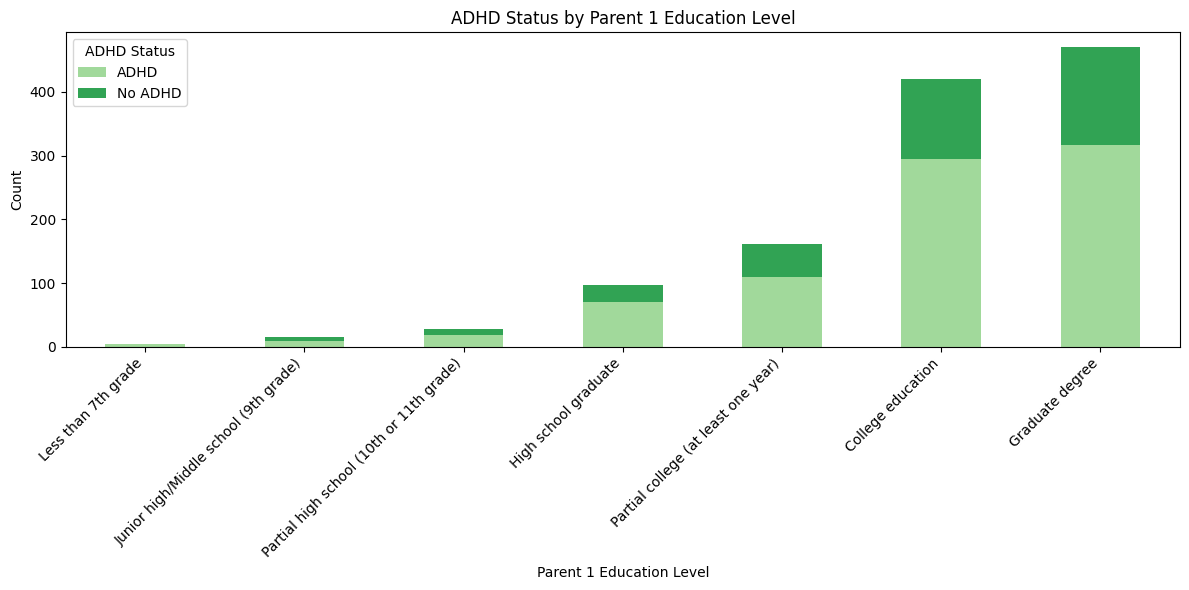

In [10]:
# Step 1: Map the education codes to labels
edu_labels = {3: 'Less than 7th grade',
    6: 'Junior high/Middle school (9th grade)',
    9: 'Partial high school (10th or 11th grade)',
    12: 'High school graduate',
    15: 'Partial college (at least one year)',
    18: 'College education',
    21: 'Graduate degree'}

# Map the numeric education codes to the labels
viz['Barratt_Barratt_P1_Edu'] = viz['Barratt_Barratt_P1_Edu'].map(edu_labels)
viz['ADHD_Status'] = viz['ADHD_Outcome'].map({1: 'ADHD', 0: 'No ADHD'})

# Step 2: Count the occurrences of each education level
edu_adhd_counts = pd.crosstab(viz['Barratt_Barratt_P1_Edu'], viz['ADHD_Status'])
edu_order = list(edu_labels.values())  # Preserves the logical education progression
edu_adhd_counts = edu_adhd_counts.reindex(edu_order)

edu_adhd_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#a1d99b', '#31a354'])

plt.title('ADHD Status by Parent 1 Education Level')
plt.xlabel('Parent 1 Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ADHD Status')
plt.tight_layout()
plt.show()

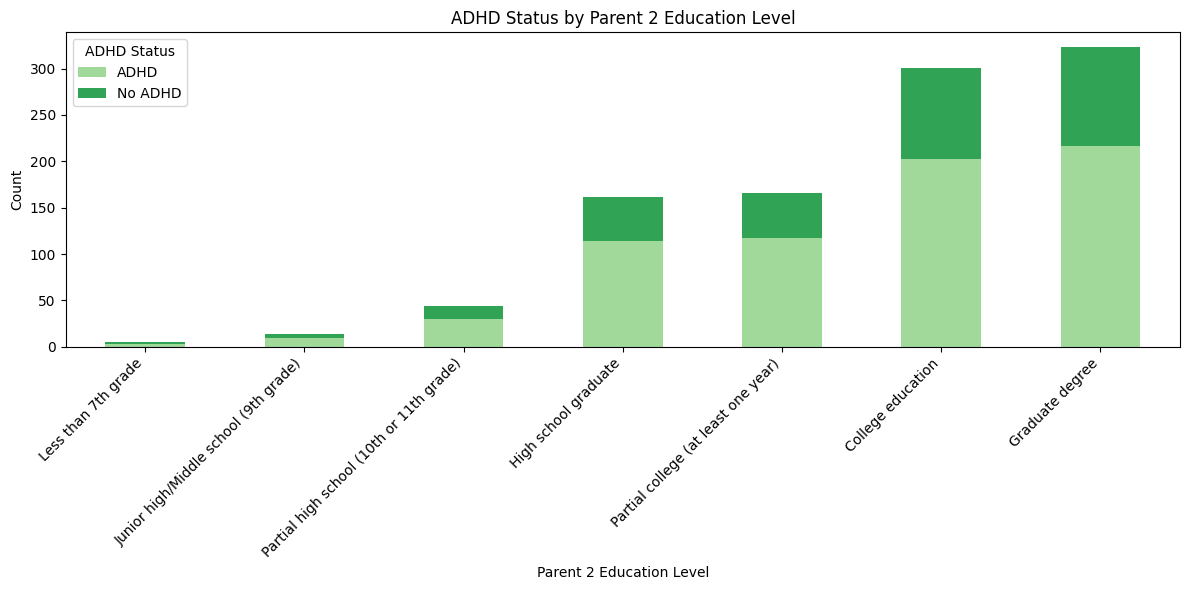

In [11]:
# Step 1: Map the education codes to labels
edu_labels = {3: 'Less than 7th grade',
    6: 'Junior high/Middle school (9th grade)',
    9: 'Partial high school (10th or 11th grade)',
    12: 'High school graduate',
    15: 'Partial college (at least one year)',
    18: 'College education',
    21: 'Graduate degree'}

# Map the numeric education codes to the labels
viz['Barratt_Barratt_P2_Edu'] = viz['Barratt_Barratt_P2_Edu'].map(edu_labels)
viz['ADHD_Status'] = viz['ADHD_Outcome'].map({1: 'ADHD', 0: 'No ADHD'})

# Step 2: Count the occurrences of each education level
edu_adhd_counts = pd.crosstab(viz['Barratt_Barratt_P2_Edu'], viz['ADHD_Status'])
edu_order = list(edu_labels.values())  # Preserves the logical education progression
edu_adhd_counts = edu_adhd_counts.reindex(edu_order)

edu_adhd_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#a1d99b', '#31a354'])

plt.title('ADHD Status by Parent 2 Education Level')
plt.xlabel('Parent 2 Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ADHD Status')
plt.tight_layout()
plt.show()

In [12]:
# # Map the numeric education codes to the labels
# viz['Barratt_Barratt_P1_Edu'] = viz['Barratt_Barratt_P1_Edu'].map(edu_labels)

# # Step 2: Count the occurrences of each education level
# edu_counts = viz['Barratt_Barratt_P1_Edu'].value_counts()

# # Step 3: Plot the bar chart for counts
# plt.figure(figsize=(10, 6))
# edu_counts.plot(kind='bar', color='skyblue')
# plt.title('Count of Parent 1 Education Levels')
# plt.xlabel('Education Level')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
# plt.tight_layout()

# # Show the plot
# plt.show()

In [13]:
# # Map the numeric education codes to the labels
# viz['Barratt_Barratt_P2_Edu'] = viz['Barratt_Barratt_P2_Edu'].map(edu_labels)

# # Step 2: Count the occurrences of each education level
# edu_counts = viz['Barratt_Barratt_P2_Edu'].value_counts()

# # Step 3: Plot the bar chart for counts
# plt.figure(figsize=(10, 6))
# edu_counts.plot(kind='bar', color='skyblue')
# plt.title('Count of Parent 2 Education Levels')
# plt.xlabel('Education Level')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
# plt.tight_layout()

# # Show the plot
# plt.show()

**Parent Occupation**

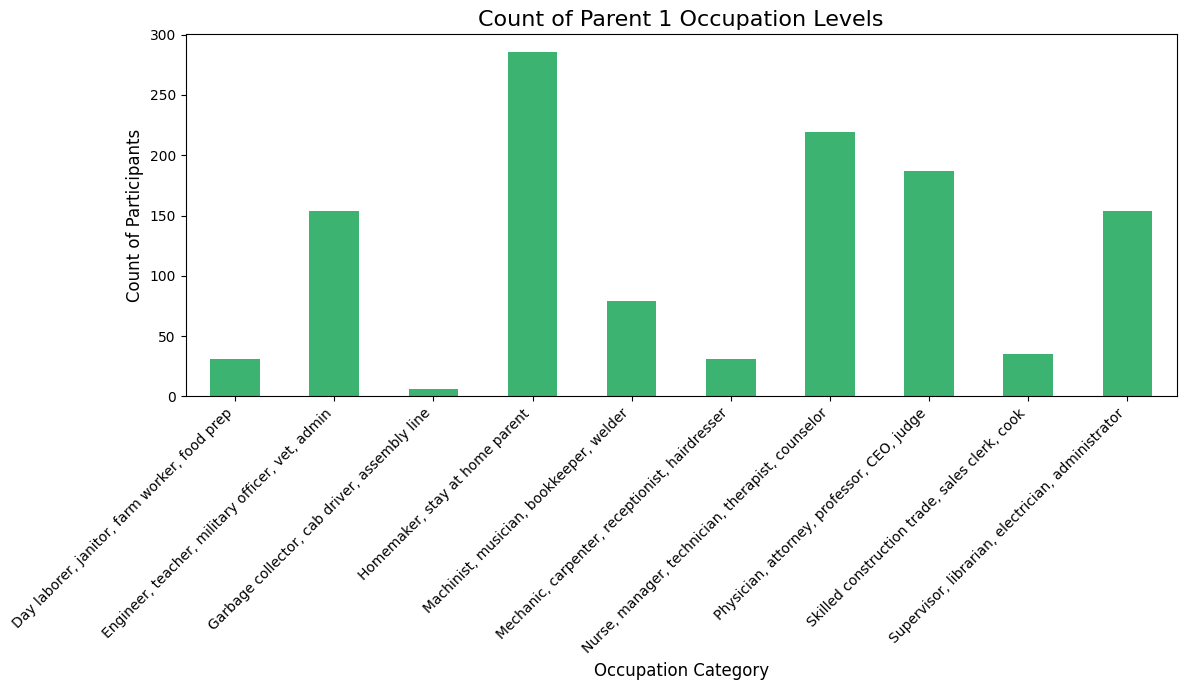

In [14]:
# Step 1: Define occupation code-to-label mapping
occ_labels = {
    0:  'Homemaker, stay at home parent',
    5:  'Day laborer, janitor, farm worker, food prep',
    10: 'Garbage collector, cab driver, assembly line',
    15: 'Skilled construction trade, sales clerk, cook',
    20: 'Mechanic, carpenter, receptionist, hairdresser',
    25: 'Machinist, musician, bookkeeper, welder',
    30: 'Supervisor, librarian, electrician, administrator',
    35: 'Nurse, manager, technician, therapist, counselor',
    40: 'Engineer, teacher, military officer, vet, admin',
    45: 'Physician, attorney, professor, CEO, judge'
}

# Step 2: Map the codes to occupation labels
viz['Barratt_Barratt_P1_Occ_Label'] = viz['Barratt_Barratt_P1_Occ'].map(occ_labels)

# Step 3: Count the frequency of each occupation group
occ_counts = viz['Barratt_Barratt_P1_Occ_Label'].value_counts().sort_index()

# Step 4: Plot the bar chart
plt.figure(figsize=(12, 7))
occ_counts.plot(kind='bar', color='mediumseagreen')

plt.title('Count of Parent 1 Occupation Levels', fontsize=16)
plt.xlabel('Occupation Category', fontsize=12)
plt.ylabel('Count of Participants', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

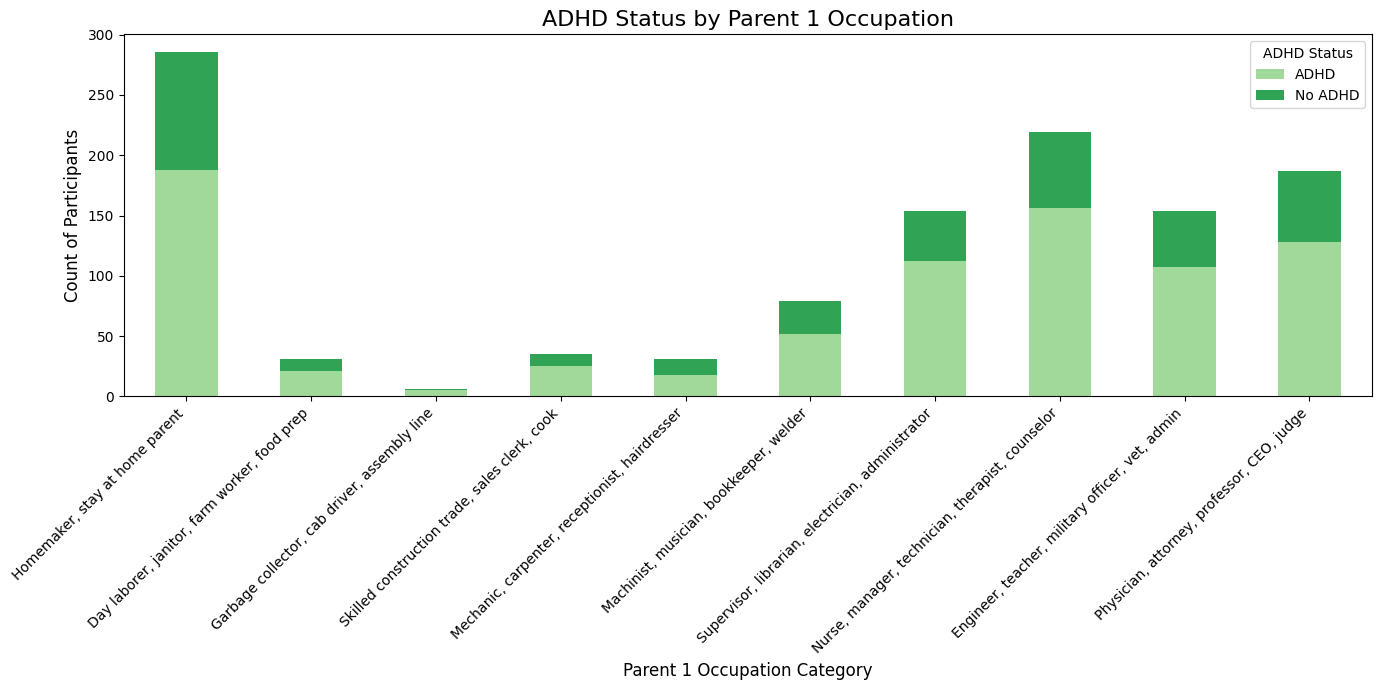

In [15]:
viz['Barratt_Barratt_P1_Occ_Label'] = viz['Barratt_Barratt_P1_Occ'].map(occ_labels)

# Step 2: Create ADHD label if not already in the dataset
viz['ADHD_Status'] = viz['ADHD_Outcome'].map({1: 'ADHD', 0: 'No ADHD'})

# Step 3: Crosstab of Occupation vs ADHD status
occ_adhd_counts = pd.crosstab(viz['Barratt_Barratt_P1_Occ_Label'], viz['ADHD_Status'])

# Step 4: Sort bars by original occupational code order
occ_order = [occ_labels[k] for k in sorted(occ_labels.keys())]
occ_adhd_counts = occ_adhd_counts.reindex(occ_order)

# Step 5: Plot stacked bar chart
occ_adhd_counts.plot(kind='bar', stacked=True, figsize=(14, 7), color=['#a1d99b', '#31a354'])

plt.title('ADHD Status by Parent 1 Occupation', fontsize=16)
plt.xlabel('Parent 1 Occupation Category', fontsize=12)
plt.ylabel('Count of Participants', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='ADHD Status')
plt.tight_layout()
plt.show()


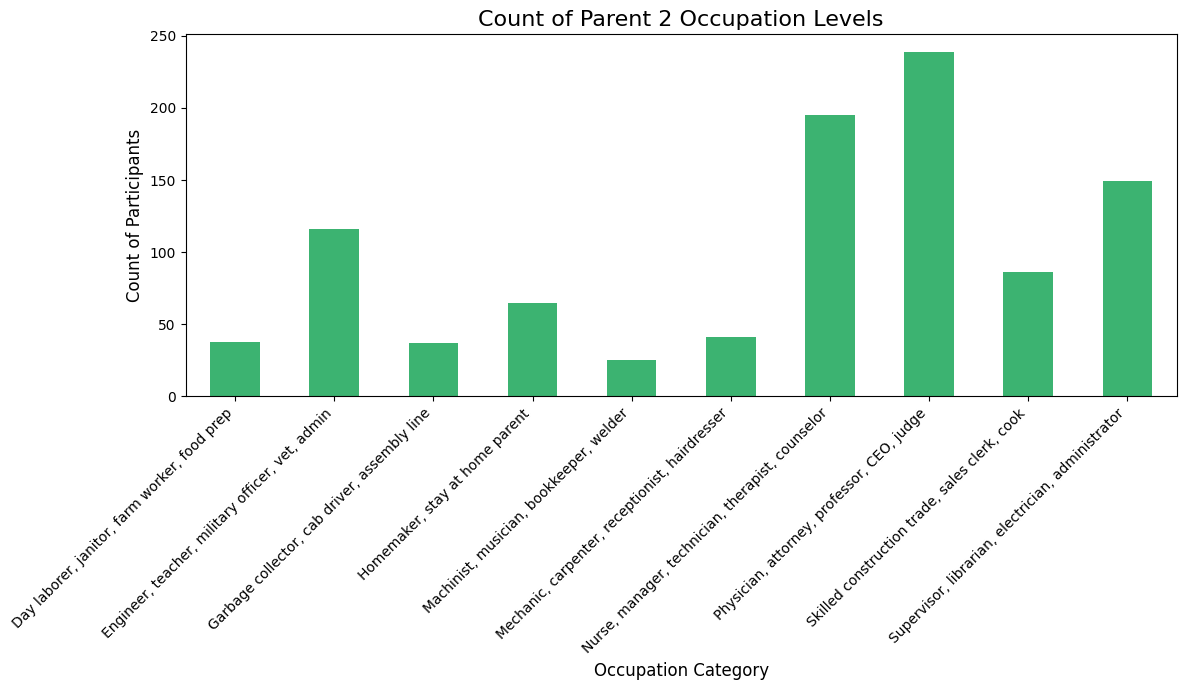

In [16]:
# Step 2: Map the codes to occupation labels
viz['Barratt_Barratt_P2_Occ_Label'] = viz['Barratt_Barratt_P2_Occ'].map(occ_labels)

# Step 3: Count the frequency of each occupation group
occ_counts = viz['Barratt_Barratt_P2_Occ_Label'].value_counts().sort_index()

# Step 4: Plot the bar chart
plt.figure(figsize=(12, 7))
occ_counts.plot(kind='bar', color='mediumseagreen')

plt.title('Count of Parent 2 Occupation Levels', fontsize=16)
plt.xlabel('Occupation Category', fontsize=12)
plt.ylabel('Count of Participants', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()


**Race Distribution**

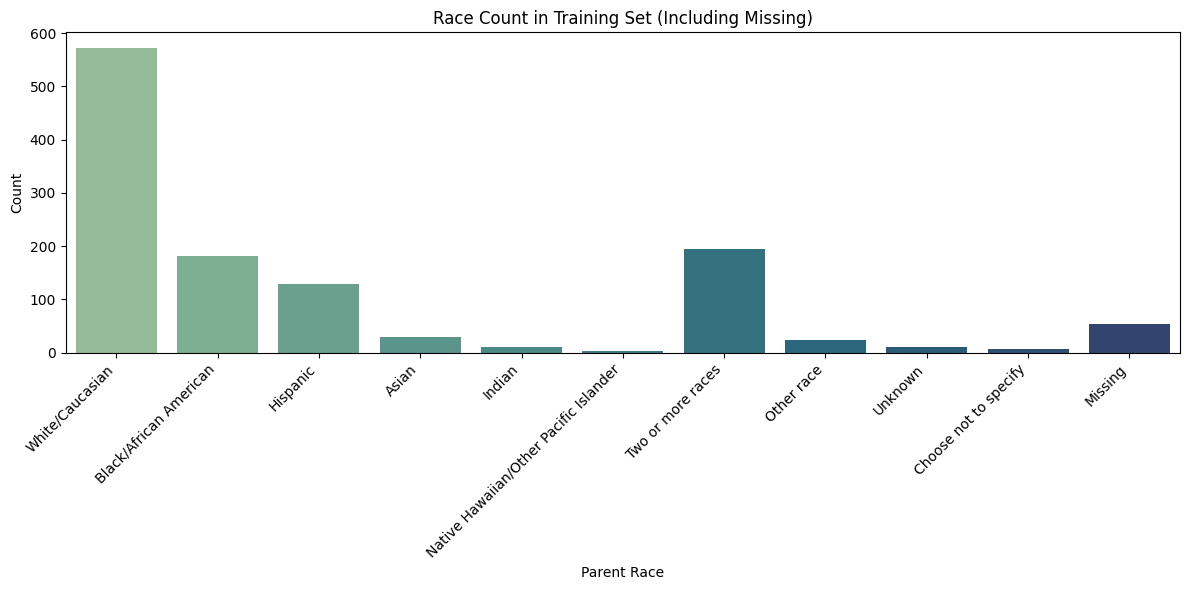

In [17]:
# Race labels
race_labels = { 0: "White/Caucasian", 1: "Black/African American", 2: "Hispanic", 3: "Asian",4: "Indian", 
               5: "Native American Indian", 6: "American Indian/Alaskan Native", 7: "Native Hawaiian/Other Pacific Islander", 
               8: "Two or more races", 9: "Other race", 10: "Unknown", 11: "Choose not to specify"}

# Get counts including NaN
race_counts = viz['PreInt_Demos_Fam_Child_Race'].value_counts(dropna=False).sort_index()

# Map codes to labels, use 'Missing' for NaNs
race_counts.index = race_counts.index.map(lambda x: race_labels.get(x, 'Missing'))

# Create DataFrame
race_df = race_counts.reset_index()
race_df.columns = ['Race', 'Count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=race_df, x='Race', y='Count', hue='Race', palette='crest', legend=False)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Parent Race")
plt.ylabel("Count")
plt.title("Race Count in Training Set (Including Missing)")
plt.tight_layout()
plt.show()


**Ethnicity Distribution**

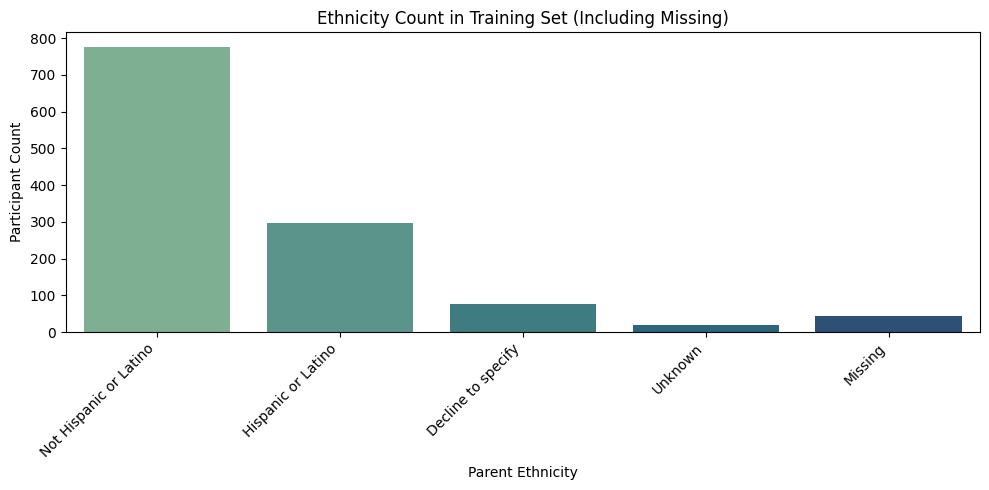

In [18]:
# Ethnicity labels
ethnicity_labels = {0: "Not Hispanic or Latino", 1: "Hispanic or Latino", 2: "Decline to specify", 3: "Unknown"}

# Get counts including NaNs
ethnicity_counts = viz['PreInt_Demos_Fam_Child_Ethnicity'].value_counts(dropna=False).sort_index()

# Map codes to labels, handle NaN
ethnicity_counts.index = ethnicity_counts.index.map(lambda x: ethnicity_labels.get(x, 'Missing'))

# Create DataFrame
ethnicity_df = ethnicity_counts.reset_index()
ethnicity_df.columns = ['Ethnicity', 'Count']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=ethnicity_df, x='Ethnicity', y='Count', hue='Ethnicity', palette='crest', legend=False)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Parent Ethnicity")
plt.ylabel("Participant Count")
plt.title("Ethnicity Count in Training Set (Including Missing)")
plt.tight_layout()
plt.show()


# Both: Data Prep

In [19]:
#Copy Trian Data & Set Participant_ID as the index
df = train_df.copy()
df.set_index('participant_id', inplace=True)

**SITE**

Only Basic Demos Study Site 4 is in both the test and training data so I will create a binary factor for this (instead of creating dummies for each study site)

In [20]:
df['Basic_Demos_Study_Site_4'] = (df['Basic_Demos_Study_Site'] == 4).astype(int) 
df.drop(columns=['Basic_Demos_Study_Site'], axis = 1, inplace = True)

**RACE**

Only [0, 1, 2, 3, 4, 7, 8, 9, 11] races are seen in both the training and testing data.. plus some of the training's demographics are small percentages of the population so we need to make a more balanced feature for prediction through merging...

_Solution: Create Race_White, Race_Black, Race_Two, Race_Hispanic, Race_Missing, and Race_Other_

In [21]:
#Create Columns based on Races
df['Race_White']       = (df['PreInt_Demos_Fam_Child_Race'] == 0).astype(int)
df['Race_Black']       = (df['PreInt_Demos_Fam_Child_Race'] == 1).astype(int)
df['Race_Hispanic']    = (df['PreInt_Demos_Fam_Child_Race'] == 2).astype(int)
df['Race_Two_or_More'] = (df['PreInt_Demos_Fam_Child_Race'] == 8).astype(int)
df['Race_Other'] = (~df['PreInt_Demos_Fam_Child_Race'].isin([0,1,2,8])).astype(int)
df['Race_Missing'] = df['PreInt_Demos_Fam_Child_Race'].isna().astype(int)

#Drop Orginial Race Column
df.drop(columns=['PreInt_Demos_Fam_Child_Race'], axis = 1, inplace=True)

**ETHNICITY**

Because this is so close to race (only determines if hispanic, decline to answer, unkown, or not hispanic) the only data it adds is 'is this participant not hispanic' so thats the data column we will keep.

In [22]:
#Create Column
df['Not_Hispanic'] = (df['PreInt_Demos_Fam_Child_Ethnicity'] != 1).astype(int)

#Drop Orginial Race Column
df.drop(columns=['PreInt_Demos_Fam_Child_Ethnicity'], axis = 1, inplace=True)

**MRI LOCATION**

Only locations 3 and 4 from the training are in the test... _Soltion is to make dummies of only 3 & 4_

In [23]:
mri_locations = [3,4]
for location in mri_locations: df[f'MRI_Scan_Location_{location}'] = (df['MRI_Track_Scan_Location'] == location).astype(int)
df.drop(columns=['MRI_Track_Scan_Location'], axis = 1, inplace = True)

**Parent Data**

_Very little parents were below partial high school so to boost balance, we would merge these smaller populations_

In [24]:
#Merging EDU for Parent 1
df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].replace(3, 6) #3 represents middle school, 7th grade
df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].replace(6, 6) #6 represents middle scool, 9th grade
df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].replace(9, 6) #9 represent partial high school

#Merging EDU for Parent 2
df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].replace(3, 6) #3 represents middle school, 7th grade
df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].replace(6, 6) #6 represents middle scool, 9th grade
df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].replace(9, 6) #9 represent partial high school

**MISSING: Track Scan + P2 Data**

**P2 Data:** _Leave as Numeric (ordinal) Data, scaling will be applied later_

**MRI Age:** _Not Missing in the Test Data so Comment out_

In [25]:
# MRI Track Scan Age Missing?
df['MRI_Track_Age_at_Scan_Missing'] = df['MRI_Track_Age_at_Scan'].isnull().astype(int)

# Barratt_Barratt_P2_Occ Missing? P2_Edu Missing?
df['Barratt_Barratt_P2_Occ_Missing'] = df['Barratt_Barratt_P2_Occ'].isnull().astype(int)
df['Barratt_Barratt_P2_Edu_Missing'] = df['Barratt_Barratt_P2_Edu'].isnull().astype(int)

**IMPUTE MISSING**

In [26]:
#IMPUTE into Mean
mean_impute_columns = ['MRI_Track_Age_at_Scan', 'EHQ_EHQ_Total', 'ColorVision_CV_Score']

for i in mean_impute_columns:   
    mean_value = df[i].mean(skipna=True)  # Compute mean excluding NaN values
    if not pd.isna(mean_value):           # Check if mean_value is NaN (i.e., all values were NaN)
        df[i] = df[i].fillna(mean_value)  # Impute missing values

In [27]:
#IMPUTE Mode 
mode_impute_columns = ['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 
                       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 
                       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 
                       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']

#impute and make missing flag
for i in mode_impute_columns:  
    mode_values = df[i].mode()
    mode = mode_values[0]       # Select the most frequent value
    df[i] = df[i].fillna(mode)  # Impute missing valuesif not: 

In [28]:
# NEED TO Recalculate SDQ_SDQ_Difficulties_Total
sdq_columns = ['SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Hyperactivity','SDQ_SDQ_Peer_Problems',
               'SDQ_SDQ_Prosocial','SDQ_SDQ_Externalizing','SDQ_SDQ_Internalizing','SDQ_SDQ_Generating_Impact']

# Row-wise sum, skip NaNs by default
df['SDQ_SDQ_Difficulties_Total'] = df[sdq_columns].sum(axis=1)
df['SDQ_Mean'] = df[sdq_columns].mean(axis=1)

apq_columns = ['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP']
df['APQ_Total'] = df[sdq_columns].sum(axis=1)
df['APQ_Mean'] = df[sdq_columns].mean(axis=1)


**DUMMIES**

In [29]:
# Create dummies and drop original columns
df = pd.get_dummies(df, columns=['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P1_Edu'], drop_first=True)

**SCALE**

_Do not scale ordinal for Random Forest or XGBoost_

In [30]:
# features_to_standardize = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan',
#                            'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',  
#                            'APQ_P_APQ_P_PP', 'APQ_Total', 'APQ_Mean', 'APQ_P_APQ_P_PM',
#                            'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total', 'SDQ_Mean',
#                            'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# # Apply the scaler to the numeric features
# df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# Base Training Data

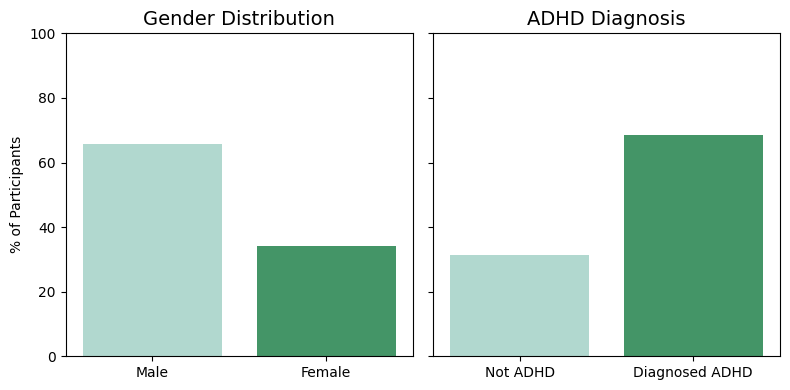

In [31]:
# Define the features and their display labels
features = {'Sex_F': {'title': 'Gender Distribution','labels': {0: 'Male', 1: 'Female'}},
            'ADHD_Outcome': {'title': 'ADHD Diagnosis','labels': {0: 'Not ADHD', 1: 'Diagnosed ADHD'}}}

# Set up figure
fig, axes = plt.subplots(1, len(features), figsize=(8, 4), sharey=True)

# Loop through features and plot each one
for i, (col, meta) in enumerate(features.items()):
    ax = axes[i]

    # Get value counts and normalize
    percent = (df[col].value_counts(normalize=True) * 100).sort_index()
    
    # Map labels
    labels = [meta['labels'].get(val, val) for val in percent.index]

    # Plot
    sns.barplot(x=labels, hue= labels, y=percent.values,ax=ax, palette='BuGn', legend=False)

    # Customize plot
    ax.set_title(meta['title'], fontsize=14)
    ax.set_ylabel('% of Participants' if i == 0 else '')
    ax.set_xlabel('')
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()


In [32]:
df.head()

,Basic_Demos_Enroll_Year,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F,Basic_Demos_Study_Site_4,Race_White,Race_Black,Race_Hispanic,Race_Two_or_More,Race_Other,Race_Missing,Not_Hispanic,MRI_Scan_Location_3,MRI_Scan_Location_4,MRI_Track_Age_at_Scan_Missing,Barratt_Barratt_P2_Occ_Missing,Barratt_Barratt_P2_Edu_Missing,SDQ_Mean,APQ_Total,APQ_Mean,Barratt_Barratt_P1_Occ_5.0,Barratt_Barratt_P1_Occ_10.0,Barratt_Barratt_P1_Occ_15.0,Barratt_Barratt_P1_Occ_20.0,Barratt_Barratt_P1_Occ_25.0,Barratt_Barratt_P1_Occ_30.0,Barratt_Barratt_P1_Occ_35.0,Barratt_Barratt_P1_Occ_40.0,Barratt_Barratt_P1_Occ_45.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0,Barratt_Barratt_P2_Edu_12.0,Barratt_Barratt_P2_Edu_15.0,Barratt_Barratt_P2_Edu_18.0,Barratt_Barratt_P2_Edu_21.0,Barratt_Barratt_P1_Edu_12.0,Barratt_Barratt_P1_Edu_15.0,Barratt_Barratt_P1_Edu_18.0,Barratt_Barratt_P1_Edu_21.0
participant_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,2019,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,48.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,6.000,48.0,6.000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
00fV0OyyoLfw,2017,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,53.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,6.625,53.0,6.625,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
04X1eiS79T4B,2017,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,65.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,8.125,65.0,8.125,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
05ocQutkURd6,2018,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,16.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2.000,16.0,2.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
06YUNBA9ZRLq,2018,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,58.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,7.250,58.0,7.250,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False


# Decision Tree Modeling

In [33]:
# Define features and target
dt = df.copy()
stratify_by = dt[['ADHD_Outcome', 'Sex_F']]
y = dt['ADHD_Outcome']
X = dt.drop(columns=['ADHD_Outcome','Sex_F'], axis=1)

# Split data into 80% train, 20% test (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= stratify_by, random_state=42)

# Model for Decision Tre
model = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_split=10, min_samples_leaf=5)

model.fit(X_train, y_train)                         # Train the model
y_prob = model.predict_proba(X_test)[:, 1]          # Get predicted probabilities
y_pred = (y_prob >= 0.5).astype(int)                # Apply threshold, default 0.5
auc = roc_auc_score(y_test, y_pred)
avg_f1 = f1_score(y_test, y_pred, average='weighted')
    
# Print classification report
print(f"\n📌 Decision Tree \n-------------------------------------------")
print(f"ROC AUC Score: {auc:.3f}")
print(f"Average F1 Score (weighted): {avg_f1:.3f}")
print("Classification Report for ADHD Prediction:")
print(classification_report(y_test, y_pred))


📌 Decision Tree 
-------------------------------------------
ROC AUC Score: 0.752
Average F1 Score (weighted): 0.798
Classification Report for ADHD Prediction:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66        76
           1       0.84      0.89      0.86       167

    accuracy                           0.80       243
   macro avg       0.77      0.75      0.76       243
weighted avg       0.80      0.80      0.80       243



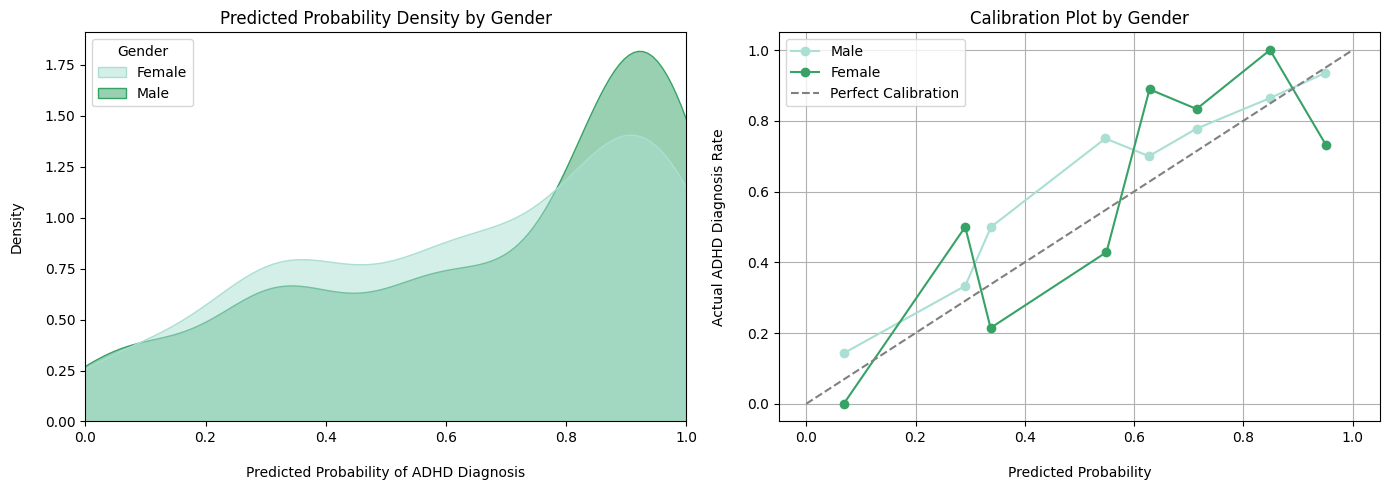

In [34]:
# Get predicted probabilities for ADHD = 1
y_prob = model.predict_proba(X_test)[:, 1]

# Combine into a single DataFrame
prob_df = pd.DataFrame({'Predicted_Prob': y_prob, 'Sex_F': dt.loc[X_test.index, 'Sex_F'], 'True_Outcome': y_test.values})
prob_df['Gender'] = prob_df['Sex_F'].map({0: 'Male', 1: 'Female'}) # Map to gender labels

# Set Seaborn theme and color palette
palette = sns.color_palette('BuGn', n_colors=2)
gender_labels = ['Male', 'Female']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KDE Plot
sns.kdeplot(data=prob_df, x='Predicted_Prob', hue='Gender', fill=True, common_norm=False, palette=palette, alpha=0.5, ax=axes[0])
axes[0].set_title('Predicted Probability Density by Gender')
axes[0].set_xlabel('Predicted Probability of ADHD Diagnosis', labelpad=15)  # Added padding
axes[0].set_ylabel('Density', labelpad=15)
axes[0].set_xlim(0, 1)

# Calibration Plot
for gender_label, color in zip(gender_labels, palette):
    group = prob_df[prob_df['Gender'] == gender_label]
    prob_true, prob_pred = calibration_curve( group['True_Outcome'], group['Predicted_Prob'], n_bins=10, strategy='uniform')
    axes[1].plot(prob_pred, prob_true, marker='o', label=gender_label, color=color)

axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[1].set_title('Calibration Plot by Gender')
axes[1].set_xlabel('Predicted Probability', labelpad=15)
axes[1].set_ylabel('Actual ADHD Diagnosis Rate', labelpad=15)
axes[1].legend()
axes[1].grid(True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots
plt.tight_layout()
plt.show()

# Randm Forest Modeling

In [35]:
rf = df.copy()

# Define features and target
stratify_by = rf[['Sex_F', 'ADHD_Outcome']]
y = rf['ADHD_Outcome']
X = rf.drop(columns=['ADHD_Outcome', 'Sex_F'], axis=1)

**CROSS-VALIDATION**

In [36]:
# Initialize StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Initialize lists to store results
y_true_all = []
y_pred_all = []

# Cross-validation loop
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the model
    model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth= 4, max_features= None, min_samples_split=5, n_estimators= 250, min_samples_leaf= 30)
    model.fit(X_train, y_train)  # Train the model
    
    # Get predicted probabilities and predictions
    y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
    y_pred = (y_prob >= 0.45).astype(int)  # Apply threshold
    
    # Collect all true and predicted values
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Calculate overall performance metrics
auc = roc_auc_score(y_true_all, y_pred_all)
avg_f1 = f1_score(y_true_all, y_pred_all, average='weighted')

# Print overall classification report and metrics
print(f"\n📌 Random Forest Cross-Validation Results \n-------------------------------------------")
print(f"ROC AUC Score: {auc:.3f}")
print(f"Average F1 Score (weighted): {avg_f1:.3f}")
# print("Overall Classification Report for ADHD Prediction:")
# print(classification_report(y_true_all, y_pred_all))


📌 Random Forest Cross-Validation Results 
-------------------------------------------
ROC AUC Score: 0.767
Average F1 Score (weighted): 0.792


**TEST-TRAIN**

In [37]:
# Split data into 80% train, 20% test (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= stratify_by, random_state=42)

model = RandomForestClassifier(random_state=42, max_depth=8, min_samples_split=5, min_samples_leaf=5, n_estimators=280)

model.fit(X_train, y_train)                         # Train the model
y_prob = model.predict_proba(X_test)[:, 1]          # Get predicted probabilities
y_pred = (y_prob >= 0.65).astype(int)                # Apply threshold, default 0.5
auc = roc_auc_score(y_test, y_pred)
avg_f1 = f1_score(y_test, y_pred, average='weighted')
    
# Print classification report
print(f"\n📌 Random Forest \n-------------------------------------------")
print(f"ROC AUC Score: {auc:.3f}")
print(f"Average F1 Score (weighted): {avg_f1:.3f}")
print("Classification Report for ADHD Prediction:")
print(classification_report(y_test, y_pred))


📌 Random Forest 
-------------------------------------------
ROC AUC Score: 0.809
Average F1 Score (weighted): 0.832
Classification Report for ADHD Prediction:
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        76
           1       0.88      0.87      0.88       167

    accuracy                           0.83       243
   macro avg       0.80      0.81      0.81       243
weighted avg       0.83      0.83      0.83       243



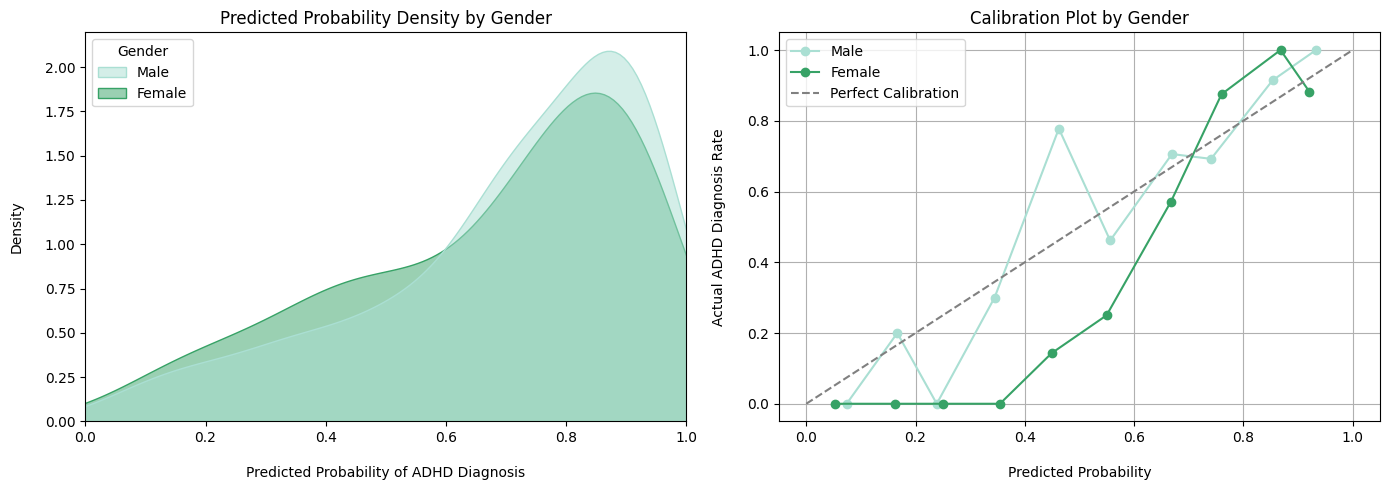

In [38]:
# Get predicted probabilities for ADHD = 1
y_prob = model.predict_proba(X_test)[:, 1]

# Combine into a single DataFrame (assuming 'rf' contains 'Sex_F' and 'True_Outcome' in 'y_test')
prob_df = pd.DataFrame({'Predicted_Prob': y_prob, 'Sex_F': rf.loc[X_test.index, 'Sex_F'], 'True_Outcome': y_test.values})
prob_df['Gender'] = prob_df['Sex_F'].map({0: 'Male', 1: 'Female'})

# Set Seaborn theme and color palette
palette = sns.color_palette('BuGn', n_colors=2)
gender_labels = ['Male', 'Female']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KDE Plot
sns.kdeplot(data=prob_df, x='Predicted_Prob', hue='Gender', fill=True, common_norm=False, palette='BuGn', alpha=0.5, ax=axes[0])
axes[0].set_title('Predicted Probability Density by Gender')
axes[0].set_xlabel('Predicted Probability of ADHD Diagnosis', labelpad=15)  # Added padding
axes[0].set_ylabel('Density', labelpad=15)
axes[0].set_xlim(0, 1)

# Calibration Plot
for gender_label, color in zip(gender_labels, palette):
    group = prob_df[prob_df['Gender'] == gender_label]
    prob_true, prob_pred = calibration_curve(group['True_Outcome'], group['Predicted_Prob'], n_bins=10, strategy='uniform')
    axes[1].plot(prob_pred, prob_true, marker='o', label=gender_label, color=color)

axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[1].set_title('Calibration Plot by Gender')
axes[1].set_xlabel('Predicted Probability', labelpad=15)
axes[1].set_ylabel('Actual ADHD Diagnosis Rate', labelpad=15)
axes[1].legend()
axes[1].grid(True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots
plt.tight_layout()
plt.show()

# XG Boost Modeling

In [39]:
xg = df.copy()
y = xg['ADHD_Outcome']
X = xg.drop(columns=['ADHD_Outcome','Sex_F'], axis=1)

**Stratified Cross-Validation**

In [50]:
# Most (Grid Search Fitted for Best Stratified K-Fold)
eval_metric = ['logloss', 'auc', 'error']
boost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric=eval_metric, n_estimators=170, max_depth=3, min_child_weight=3.5, learning_rate=0.05, gamma=0.15, scale_pos_weight= 2)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Initialize StratifiedKFold

# Apply cross-validation to get predicted probabilities
y_prob = cross_val_predict(boost_model, X, y, cv=skf, method='predict_proba')

scoring = {'f1': make_scorer(f1_score), 'roc_auc': 'roc_auc'}           # Define scorers
cv_results = cross_validate(boost_model, X, y, cv=skf, scoring=scoring) # Cross-validate with both scores

# Print results
print(f"Average F1 score: {np.mean(cv_results['test_f1']):.4f}")
print(f"Average AUC ROC score: {np.mean(cv_results['test_roc_auc']):.4f}")

Average F1 score: 0.8676
Average AUC ROC score: 0.8408


**Test-Train**

In [86]:
# BALANCE adhd outcomes
counter = Counter(y)
scale_pos_weight = counter[0] / counter[1] # log(1 + ratio) to prevent over compensation np.log1(counter[0] / counter[1])

# Most (Grid Search Fitted for Best Stratified K-Fold)
eval_metric = ['logloss', 'auc', 'error']
boost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric=eval_metric, n_estimators=200, max_depth=5,  min_child_weight=5,  learning_rate=0.1, gamma=0, scale_pos_weight= 3.5)

# Final train-test split + Fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
boost_model.fit(X_train, y_train)

# Predict probabilities and apply threshold
y_prob = boost_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.65).astype(int)

# Evaluate
auc = roc_auc_score(y_test, y_prob)  # AUC uses probabilities
avg_f1 = f1_score(y_test, y_pred, average='weighted')  # or 'macro'

print(f"ROC AUC Score: {auc:.3f}")
print(f"Average F1 Score (weighted): {avg_f1:.3f} \n ----------------------------------------------")
print(f"Classification Report for ADHD Prediction:\n{classification_report(y_test, y_pred)}")

ROC AUC Score: 0.821
Average F1 Score (weighted): 0.790 
 ----------------------------------------------
Classification Report for ADHD Prediction:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        77
           1       0.83      0.88      0.85       166

    accuracy                           0.79       243
   macro avg       0.77      0.74      0.75       243
weighted avg       0.79      0.79      0.79       243



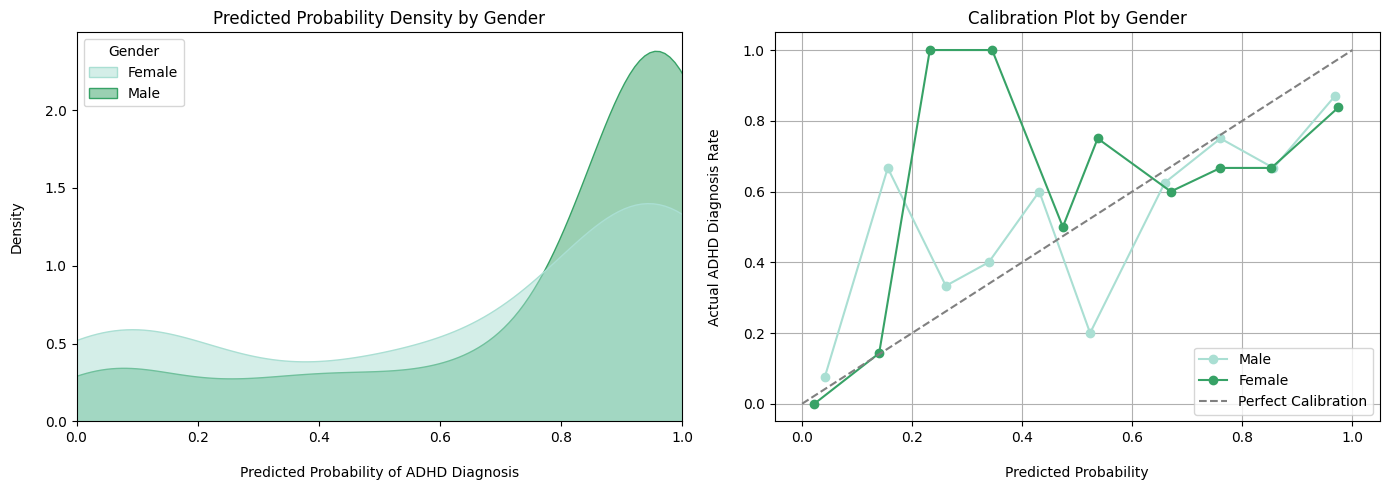

In [87]:
# Get predicted probabilities for ADHD = 1
y_prob = boost_model.predict_proba(X_test)[:, 1]

# Combine into a single DataFrame
prob_df = pd.DataFrame({'Predicted_Prob': y_prob, 'Sex_F': xg.loc[X_test.index, 'Sex_F'], 'True_Outcome': y_test.values})
prob_df['Gender'] = prob_df['Sex_F'].map({0: 'Male', 1: 'Female'}) # Map to gender labels

# Set Seaborn theme and color palette
palette = sns.color_palette('BuGn', n_colors=2)
gender_labels = ['Male', 'Female']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KDE Plot
sns.kdeplot(data=prob_df, x='Predicted_Prob', hue='Gender', fill=True, common_norm=False, palette='BuGn', alpha=0.5, ax=axes[0])
axes[0].set_title('Predicted Probability Density by Gender')
axes[0].set_xlabel('Predicted Probability of ADHD Diagnosis', labelpad=15)  # Added padding
axes[0].set_ylabel('Density', labelpad=15)
axes[0].set_xlim(0, 1)

# Calibration Plot
for gender_label, color in zip(gender_labels, palette):
    group = prob_df[prob_df['Gender'] == gender_label]
    prob_true, prob_pred = calibration_curve( group['True_Outcome'], group['Predicted_Prob'], n_bins=10, strategy='uniform')
    axes[1].plot(prob_pred, prob_true, marker='o', label=gender_label, color=color)

axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
axes[1].set_title('Calibration Plot by Gender')
axes[1].set_xlabel('Predicted Probability', labelpad=15)
axes[1].set_ylabel('Actual ADHD Diagnosis Rate', labelpad=15)
axes[1].legend()
axes[1].grid(True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots
plt.tight_layout()
plt.show()